In [2]:
# !pip install torch torchvision torchaudio scikit-learn

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
import os

In [9]:
!du -sh "/content/drive/MyDrive/foodguard/combined_data"

480M	/content/drive/MyDrive/foodguard/combined_data


In [5]:
!cp -r "/content/drive/MyDrive/foodguard/combined_data" "/content/combined_data"

In [6]:
DATA_DIR = "/content/combined_data"

In [7]:
!ls "/content/drive/MyDrive/foodguard/combined_data" | head

apple
banana
BEANS
beetroot
bell pepper
cabbage
CAKE
CANDY
capsicum
carrot


In [8]:
!ls "/content/combined_data" | head

apple
banana
BEANS
beetroot
bell pepper
cabbage
CAKE
CANDY
capsicum
carrot


In [31]:
DATA_DIR = "/content/combined_data"

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomErasing(p=0.3),
    transforms.ToTensor(),
])


test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

full_ds = datasets.ImageFolder(DATA_DIR, transform=train_tfms)
class_names = full_ds.classes
num_classes = len(class_names)

train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size

train_ds, val_ds = random_split(full_ds, [train_size, val_size])

val_ds.dataset.transform = test_tfms

In [32]:
train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True,
    num_workers=4, pin_memory=True
)

val_loader = DataLoader(
    val_ds, batch_size=32, shuffle=False,
    num_workers=4, pin_memory=True
)


In [20]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = resnet50(weights=ResNet50_Weights.DEFAULT)
# model.fc = nn.Linear(model.fc.in_features, num_classes)
# model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr=1e-4)

# from torch.amp import GradScaler
# scaler = GradScaler(device=device)

# writer = SummaryWriter()

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet50(weights=ResNet50_Weights.DEFAULT)

# freeze all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze only last block + fc
for param in model.layer4.parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

from torch.amp import GradScaler
scaler = GradScaler(device=device)

writer = SummaryWriter()

In [34]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

In [35]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

EPOCHS = 20
best_val_acc = 0
patience = 4
early_stop_counter = 0

scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(EPOCHS):

    # train
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda'):
            preds = model(images)
            loss = criterion(preds, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        correct += (preds.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss / len(train_loader))

    # validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)

            val_loss += loss.item()
            correct += (preds.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    #lr
    old_lr = optimizer.param_groups[0]["lr"]
    scheduler.step(val_acc)
    new_lr = optimizer.param_groups[0]["lr"]

    if new_lr < old_lr:
        print(f" Learning Rate reduced: {old_lr:.6f} → {new_lr:.6f}")

    #save best model
    if val_acc > best_val_acc:
        torch.save(model.state_dict(), "best_model.pth")
        best_val_acc = val_acc
        early_stop_counter = 0
        print("Saved new BEST model!")

    else:
        early_stop_counter += 1
        print(f" No improvement. Early stop counter = {early_stop_counter}/{patience}")

        if early_stop_counter >= patience:
            print("Early Stopping Activated!")
            break

Epoch 1/20 | Train Acc: 0.1443 | Val Acc: 0.2705
Saved new BEST model!
Epoch 2/20 | Train Acc: 0.5261 | Val Acc: 0.4841
Saved new BEST model!
Epoch 3/20 | Train Acc: 0.7761 | Val Acc: 0.6318
Saved new BEST model!
Epoch 4/20 | Train Acc: 0.9045 | Val Acc: 0.7386
Saved new BEST model!
Epoch 5/20 | Train Acc: 0.9631 | Val Acc: 0.7614
Saved new BEST model!
Epoch 6/20 | Train Acc: 0.9818 | Val Acc: 0.7864
Saved new BEST model!
Epoch 7/20 | Train Acc: 0.9949 | Val Acc: 0.7727
 No improvement. Early stop counter = 1/4
Epoch 8/20 | Train Acc: 0.9977 | Val Acc: 0.7932
Saved new BEST model!
Epoch 9/20 | Train Acc: 0.9994 | Val Acc: 0.7841
 No improvement. Early stop counter = 1/4
Epoch 10/20 | Train Acc: 1.0000 | Val Acc: 0.7932
 No improvement. Early stop counter = 2/4
Epoch 11/20 | Train Acc: 1.0000 | Val Acc: 0.7773
🔽 Learning Rate reduced: 0.000100 → 0.000050
 No improvement. Early stop counter = 3/4
Epoch 12/20 | Train Acc: 0.9989 | Val Acc: 0.7955
Saved new BEST model!
Epoch 13/20 | Train 

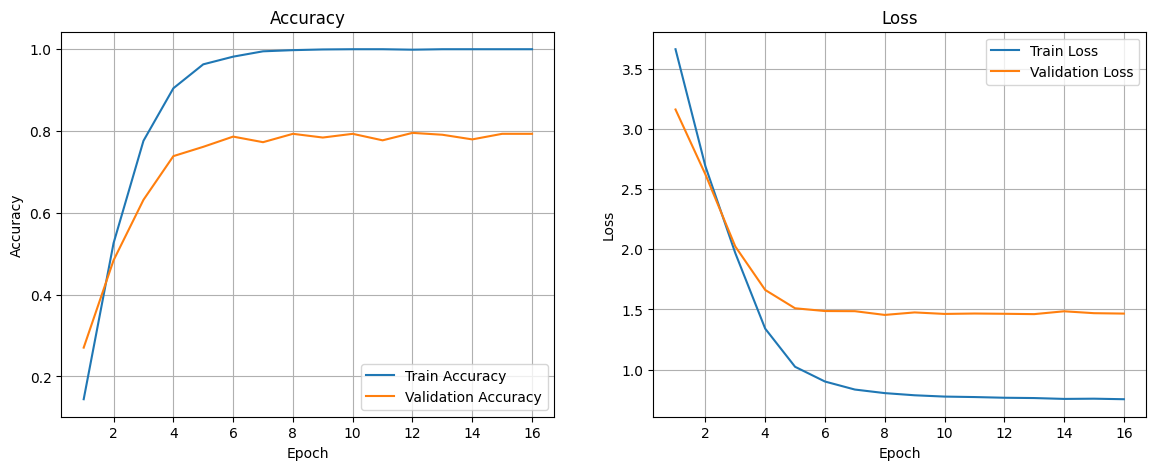

In [37]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc_list) + 1)

plt.figure(figsize=(14,5))

#  Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_acc_list, label="Train Accuracy")
plt.plot(epochs, val_acc_list, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

#  Loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss_list, label="Train Loss")
plt.plot(epochs, val_loss_list, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()


In [38]:
!cp best_model.pth "/content/drive/MyDrive/foodguard/models/classifiers/classifier_resnet50.pth"

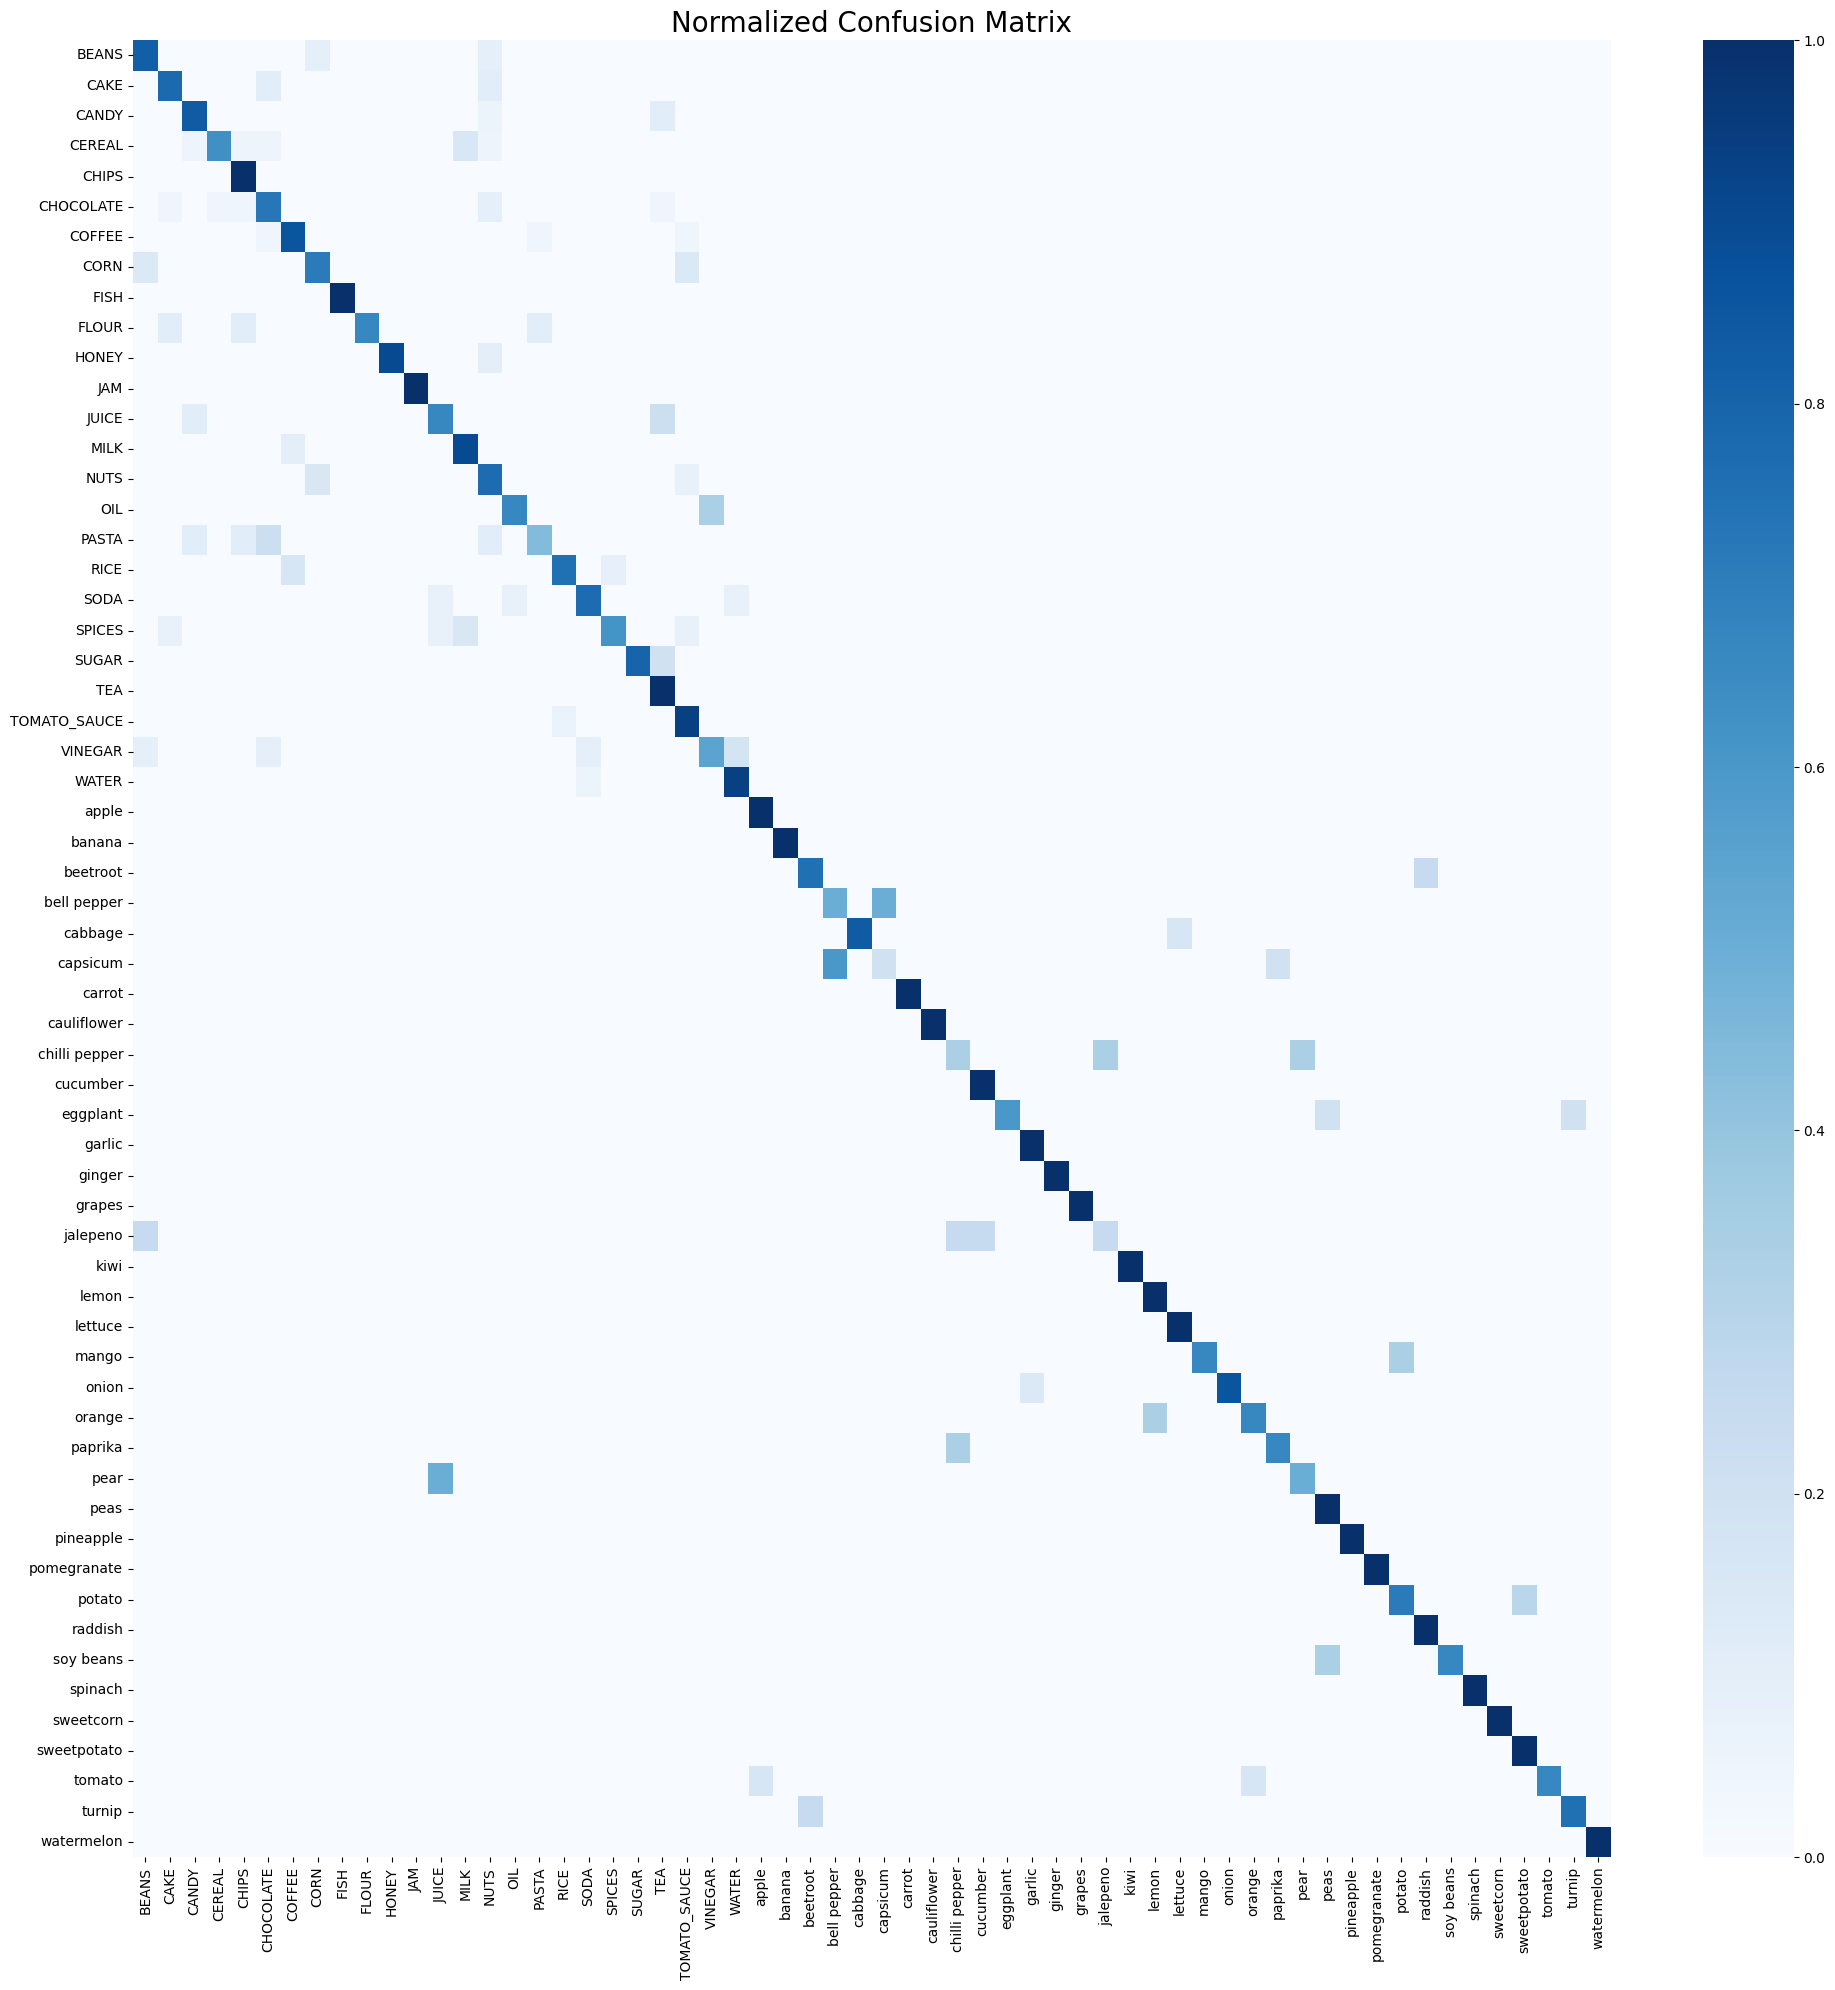


 Top 5 Most Confused Class Pairs:

VINEGAR  →  WATER   | Count = 2
CHOCOLATE  →  NUTS   | Count = 2
OIL  →  VINEGAR   | Count = 3
capsicum  →  bell pepper   | Count = 3
CEREAL  →  MILK   | Count = 3


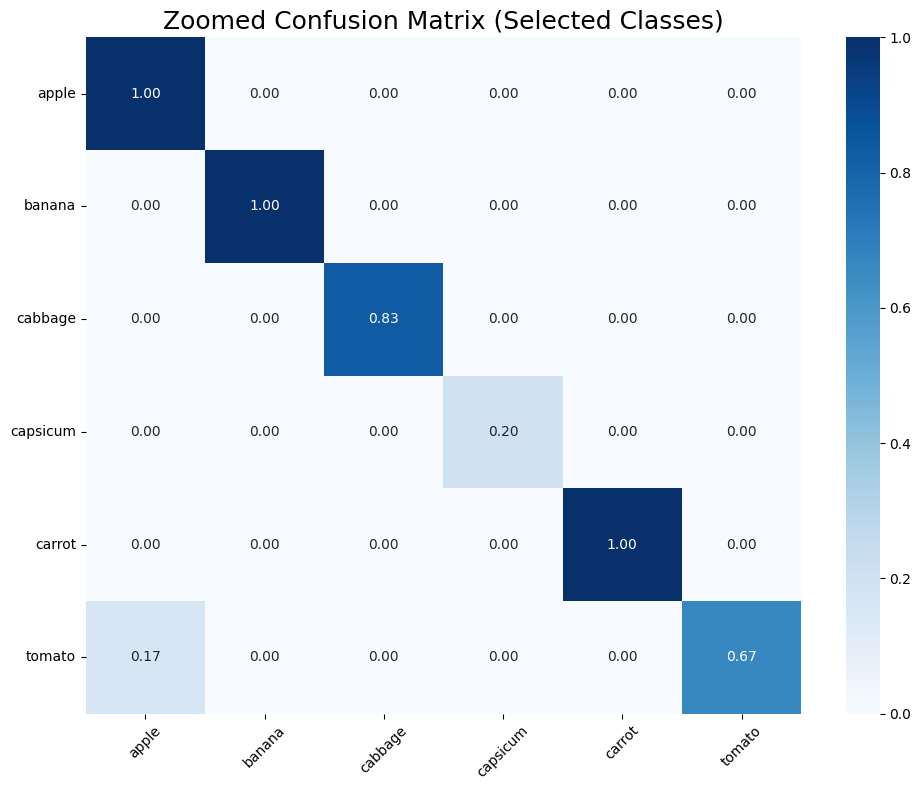

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# -------------------------
# Compute Confusion Matrix
# -------------------------
cm = confusion_matrix(all_labels, all_preds)
cm_norm = confusion_matrix(all_labels, all_preds, normalize='true')

# -------------------------
# 1. LARGE CONFUSION MATRIX (READABLE)
# -------------------------
plt.figure(figsize=(20, 20))
sns.heatmap(cm_norm, annot=False, cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix", fontsize=20)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# -------------------------
# 2. TOP 5 MOST CONFUSED CLASS PAIRS
# -------------------------
errors = cm.copy()
np.fill_diagonal(errors, 0)  # ignore correct predictions

flat = errors.flatten()
top_idx = flat.argsort()[-5:]  # top 5 mistakes

print("\n Top 5 Most Confused Class Pairs:\n")
for idx in top_idx:
    true = idx // cm.shape[1]
    pred = idx % cm.shape[1]
    print(f"{class_names[true]}  →  {class_names[pred]}   | Count = {cm[true][pred]}")

# -------------------------
# 3. ZOOMED-IN CONFUSION MATRIX (OPTIONAL)
#    Choose 10–12 common grocery items
# -------------------------
subset = ["apple", "banana", "cabbage", "capsicum", "carrot",
          "chocolate", "milk", "pasta", "sweetlime", "tomato"]

# Make sure all exist
subset = [c for c in subset if c in class_names]

idx = [class_names.index(c) for c in subset]
cm_small = cm_norm[np.ix_(idx, idx)]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_small, annot=True, cmap="Blues",
            xticklabels=subset, yticklabels=subset, fmt=".2f")
plt.title("Zoomed Confusion Matrix (Selected Classes)", fontsize=18)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
